# Сопоставление векторов с помощью библиотеки Faiss

### Постановка задачи

В рамках подготовки в Мастерской  поставлена задача сопоставления и поиска наиболее похожих товаров. Сопоставление (англ. matching - соответствие) - одна из базовых задач машинного обучения, которая встречается в информационном поиске, компьютерном зрении, рекомендательных системах и т.п. Задача состоит в использовании алгоритмов приближенного поиска ближайших соседей ранжирующей модели для предсказания наиболее схожих товаров.

В рамках выполнении задачи проделаны следующие этапы:

- подготовка и исследование исходных данных;
- подбор ранжирующей модели и ее оптимальных параметров;
- оценка модели метрикой accuracy@5;
- создание и подготовка данных для ml модели;
- подбор оптимальной модели машинного обучения с целью улучшить качество предсказания ранжирующей модели;
- оценка результатов после введения модели машинного обучения в алгоритм поиска схожих товаров.

<div style="border:solid Red 2px; padding: 40px">
<b>Выводы по проекту:</b>  
    
Для проекта Мастерской разработана модель ранжирования библиотеки Faiss, позволяющая определить наиболее схожие товары метоом ближайших соседей по векторам признаков. В дополнение к Faiss внедрена модель классификации XGBoost, позволяющая из бОльшего числа кандидатов определить какие из них схожи с исходным вектором, а какие нет. По вероятности предсказания модели классификации сортируются кандидаты. 

Среди исходных признаков имелись такие, у которых значения имели не нормальлное распределение. В результате математических операций выявлено, что один из признаков, в большинстве случаев, для верных ответов имел значение равное единице, а для остальных кандидатов отличался от единицы. Так же вероятно что часть других признаков являлись категориальные и по этой причине имели отличное от нормального распределения. Интересным замечанием было отличие указанных признаков по количеству символов после запятой.

После удаления данных признаков в тестовой выборке появилось порядка 2% дубликатов. 

Для модели ранжирования Faiss подобраны параметры и модель с точностью **70,9%** верно сопоставляла один из пяти кандидатов. При этом время на разметку и сопоставление кандидатов адекватные. При использовании индекса Flat можно немного улучшить результат, но при этом время поиска кандидатов сильно увеличится, за счет того, что модель будет сравнивать с каждым кандидатом в базе по отдельности и при увеличении базы (а они иногда достигают десятков и сотен Гб) скорость поиска будет увеличиваться.

Другим способом улучшение результат является подбор большего количества кандидатов. Например среди 100 кандидатов метрика увеличится до 76,9%, а при 200 уже 78,3%, далее увеличение количества кандидатов недает такой прирост в результате. Такой метод удобно использовать с моделью классификации, в случае если модель верно предсказывает в более чем 90,5% случаев.

В качестве такой модели испробована модель классификации XGBoost. Для нее подобраны оптимальные гиперпараметры с помощью библиотеки Optuna. С указанными гиперпараметрами модель из 200 кандидатов выводит с вероятностью **59.8%** из 5 кандидатов предлагает верный. С вероятностью **65,8%** из 10 кандидатов выбирает 5 с одним правильным.  К сожалению при имеющейся конфигурации модели, результат метрики ухудшается и в реализацию запускать нет смысла. 

Рекомендации для улучшения качества предсказаний:
- среди удаленных признаков проверить на принадлежность к категориальным;
- воспользоваться другими моделями машинного обучения для классификации;
- воспользоваться другой ранжирующей моделью;
- провести альтернативные математические операции с векторами (в текущей работе использовано деление исходного вектора на вектора кандидатов).</div>

### Подготовка исходных данных

Загружаем все необходимые для исследования библиотеки.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import faiss

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer, f1_score


from xgboost import XGBClassifier


import optuna
from optuna.samplers import TPESampler

Среди исходных данных имеем 4 файла формата .csv:

- base.csv - исходная база признаков товаров;
- train.csv - тренировочный датасет с признаками товаров и ответами наиболее похожих товаров. На данном датасете можно тренировать ml модель, для улучшения целевой метрики accuracy@5;
- validation.csv - валидационный датасет признаков товаров, по которой необходимо считать итоговый показатель метрики;
- validation_answer.csv - ответы для валидационного датасета.

Загружаем базу признаков товаров и тренировочный датасет, в качестве индексов указываем нулевой признак, в котором записан id товара. Значение и тип признаков не известно, все признаки не поддаются какому-либо объяснению.

In [2]:
df_base = pd.read_csv("base.csv", index_col=0)
df_train = pd.read_csv("train.csv", index_col=0)

На тренировочном датасете посмотрим гистограммы распределения значений признаков.

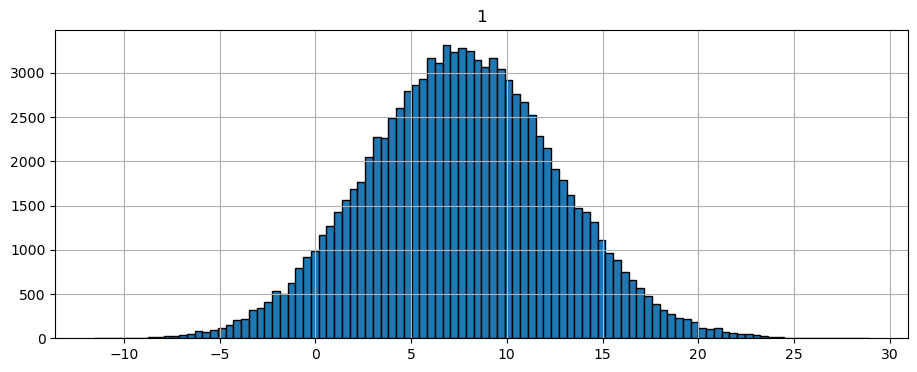

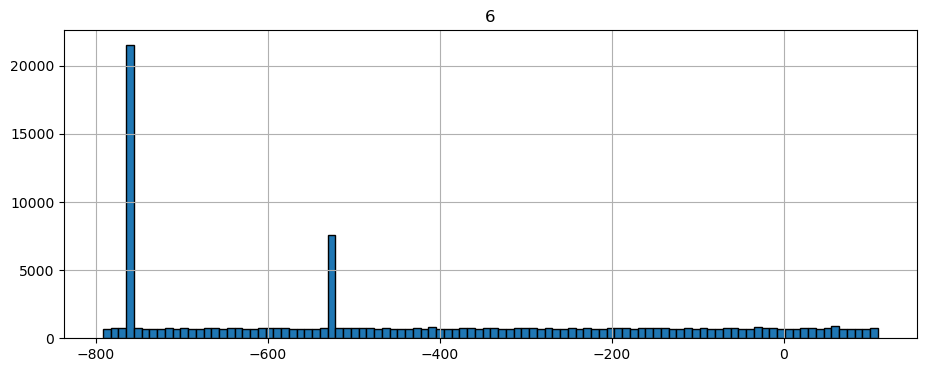

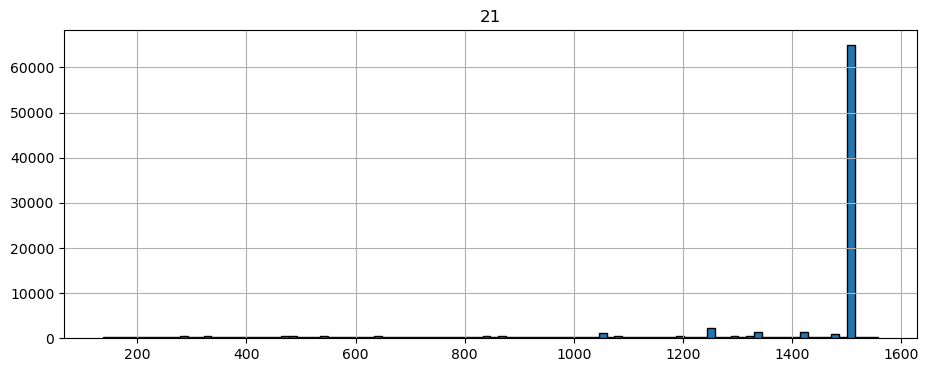

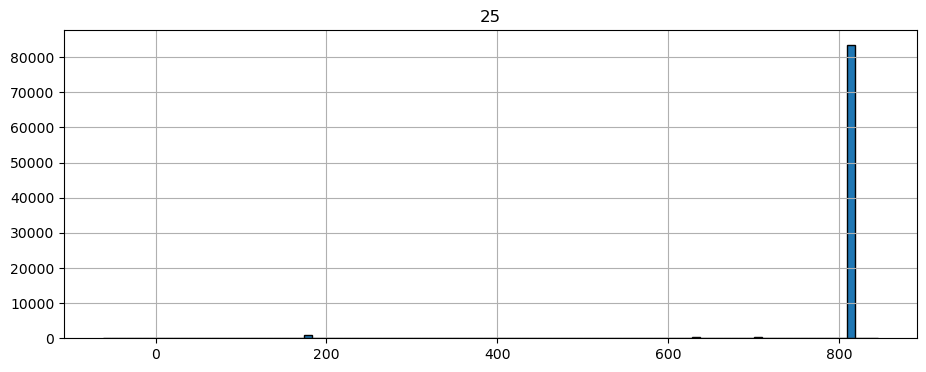

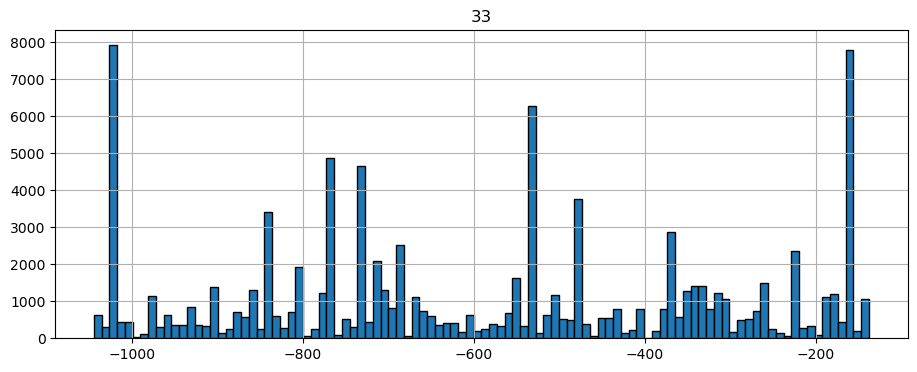

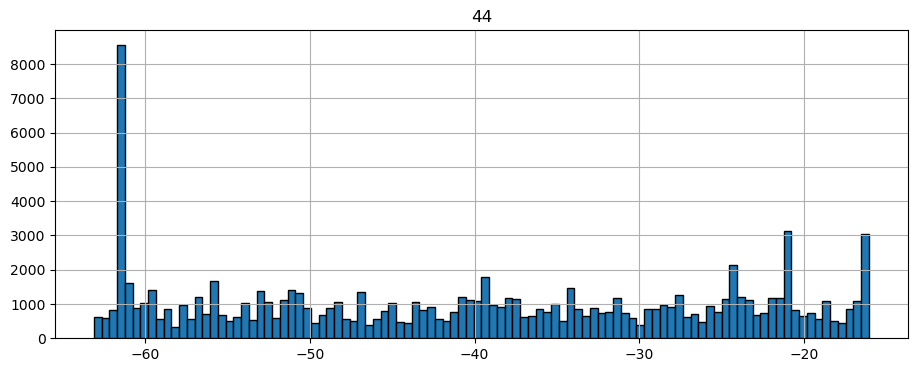

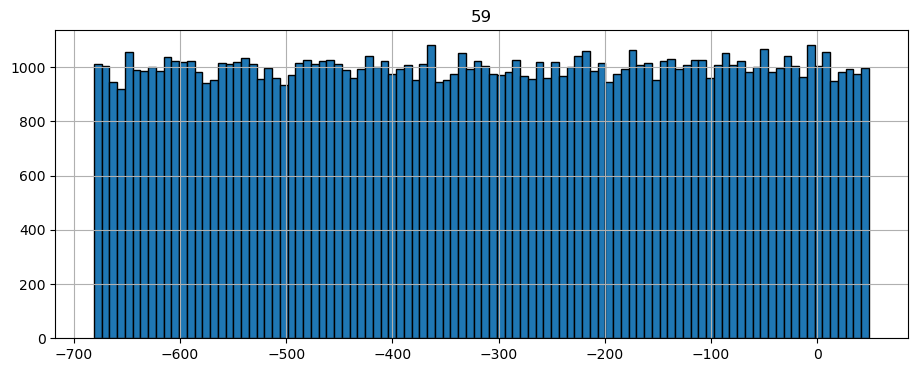

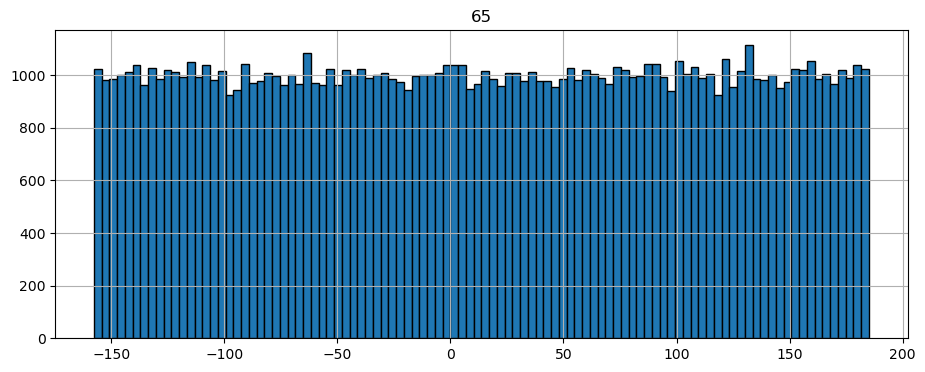

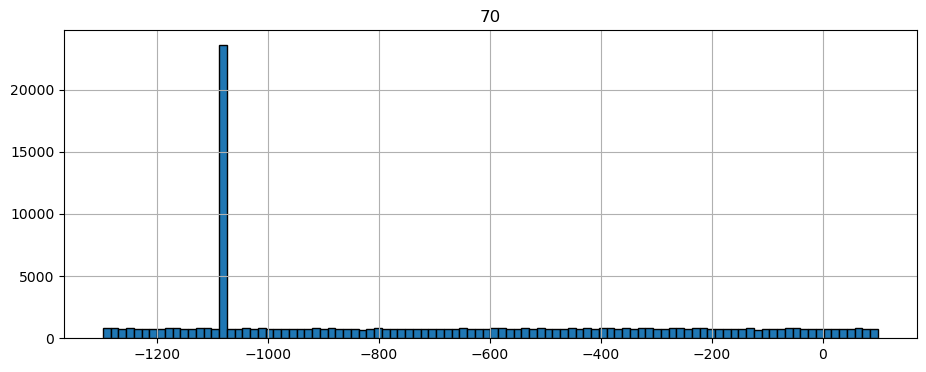

In [3]:
for col in [1, 6, 21, 25, 33, 44, 59, 65, 70]:
    df_train[df_train.columns[col]].hist(figsize=(11,4), bins=100, edgecolor='black')
    plt.title(df_train.columns[col])
    plt.show()

Как видно из гистограмм, большинство признаков имеют нормальное распределение. Но имеются признаки никак не связанные с нормальным распределением. В первой иттерации удалим эти признаки, оставим лишь признак '6', так как при более глубоком исследовании признаков, при делении рассматриваемого вектора признаков на вектора кандидатов, в большинстве случаев, принимал значение 1 для верных кандидатов и другие значения для некорректных. **Вероятно признаки 33, 59, 65 являются категориями и их необходимо использовать в исследовании.** Так же данные признаки отличаются от других количеством символов после запятой. Все признаки с нормаьлным распределением имеют менше цифр после запятой.

В соответствии с проведенным анализом признаков удаляем недостоверные признаки.

In [4]:
df_base = df_base.drop(['21', '25', '33', '44', '59', '65', '70'], axis=1)

Для всего датасета проводим стандартизацию данных, таким образом получилось улучшить предсказание библиотеки Faiss на тренировочных данных на 1-1,5 базисных процента.

In [5]:
scaler = StandardScaler()
scaler.fit(df_base[df_base.columns])
df_base[df_base.columns] = scaler.transform(df_base[df_base.columns])

Для тренировочного датасета проделываем аналогичные операции. В процессе исследовательского анализа данных обнаружено появление дубликатов данных при удалении признаков.

In [6]:
for i in ['21', '25', '33', '44', '59', '65', '70']:
    df_train = df_train.drop([i], axis=1)
    print(f'Delete column {i}, have duplicated:{df_train.duplicated().sum()}')

Delete column 21, have duplicated:0
Delete column 25, have duplicated:0
Delete column 33, have duplicated:0
Delete column 44, have duplicated:0
Delete column 59, have duplicated:2038
Delete column 65, have duplicated:2046
Delete column 70, have duplicated:2121


Для стандартизации тренировочного датасета необходимо отделить целевой признак от других. 

In [7]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)
df_train[df_train.columns] = scaler.transform(df_train[df_train.columns])

### Настройка модели Faiss

**Facebook AI Research Similarity Search** – разработка команды Facebook AI Research для быстрого поиска ближайших соседей и кластеризации в векторном пространстве. Высокая скорость поиска позволяет работать с очень большими данными – до нескольких миллиардов векторов.

Главное понятие в **FAISS** – это **index**, и, по сути, это просто набор параметров и векторов. Наборы параметров бывают совершенно разные и зависят от нужд пользователя. Векторы могут оставаться неизменными, а могут перестраиваться. Некоторые индексы доступны для работы сразу после добавления в них векторов, а некоторые требуют предварительного обучения. Имена векторов хранятся в индексе: либо в нумерации от 0 до n, либо в виде числа, влезающего в тип Int64.

В качестве индекса выбран **IndexIVFFlat**. Он позволяет разделить область пространства на части, в каждом из которых выбирается наиболее похожий на остальные вектор. Поэтому поиск наиболее похожего вектора сводится к сравнению исходного вектора с каждым из центроидов. Параметром nprobe мы задаем в какое количество наиболее схожих частей "заглянет" модель. В данном индексе слабое место - граница нескольких частей. Если выбрать nprobe равным 1, истинный ответ может быть рядом с границей области данной части и мы не сможем выбрать его. В то же время за счет малого количества nprobe время подбора кандидатов сильно ускоряется в сравнении с индексом **Flat**, который сравнивает исходный вектор с каждым. Но у индекса Flat итоговый результат будет самый высокий, за счет количества перебора соотвествий.

Основная идея **IndexIVFFlat** индекса состоит в том, чтобы сгруппировать большой набор векторов по частям с помощью алгоритма k-means, каждой части поставив в соответствие центроиду, – вектор, являющийся выбранным центром для данного кластера. Поиск осуществляется через минимальное расстояние до центроида, и только потом искать минимальные расстояния среди векторов в том кластере, что соответствует данному центроиду.

Задаем основные параметры Faiss, количество признаков, количество частей, на которые стоит разбить область признаков базы, а так же применяемый index.

In [8]:
# Количество измерений в базе данных
dims = df_base.shape[1]
# Количество частей области признаков, приблизительно корень из количества товаров в базе
idx_l2 = faiss.index_factory(dims, 'IVF1708,Flat')

По большому счету среди изменяемых параметров Faiss можно выделить количество кандидатов и nprobe. Первый указывает сколько кандидатов брать для оценки целевой метрики. Данное значение будет полезно в случае когда модель будет предсказывать лучше Faiss. Второй же параметр указывает в каком количестве частей пространства признаков искать кандидатов для сопоставления. Для подбора этих параметров проведено опытное исследование с построением графиков зависимости целевой метрики от значения параметра.

Первым параметром подбирался значение nprobe. Для этого для значений от 1 до 95 посчитана целевая метрика.

In [9]:
nprobe_test = pd.read_csv('nprobe_test.csv')

<div style="border:solid Red 2px; padding: 40px">

    Код для получения графиков:

```
nprobe_number = []
nprobe_result = []

for i in range(1, 60, 5):
    idx_l2.nprobe = i
    r, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 25)
    acc = 0
    for target, el in zip(targets.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])
    
    nprobe_number.append(i)
    nprobe_result.append(100 * acc / len(idx))
```

</div>

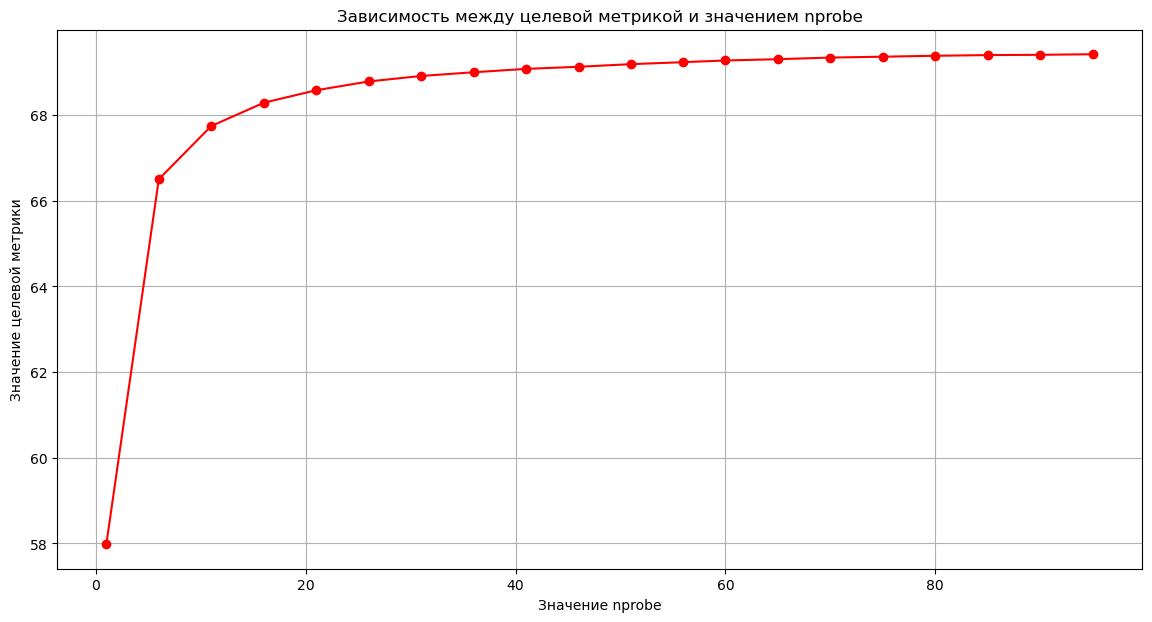

In [10]:
plt.figure(figsize=(14, 7))
plt.plot(nprobe_test.number, nprobe_test.result, 'ro-')
plt.grid(True)
plt.title('Зависимость между целевой метрикой и значением nprobe')
plt.ylabel('Значение целевой метрики')
plt.xlabel('Значение nprobe')
plt.show()

Как видно из графика, при значениях более 40 график имеет более пологое изменение. В качестве используемого значения принято решение взять значение 45. Параметр nprobe влияет на скорость подбора кандидатов. Чем больше значение nprobe, тем в большем количестве частей модель подбирает кандидатов. 

Далее расчитана целевая метрика в зависимости от количества кандидатов. По заданию метрика считается для 5 кандидатов, но ml модель может немного улучшить метрику. максимальное значение, которое можно получить при условии 100 точности модели будет равно значениям графика ниже.

In [11]:
candidats_test = pd.read_csv('candidats_test.csv')

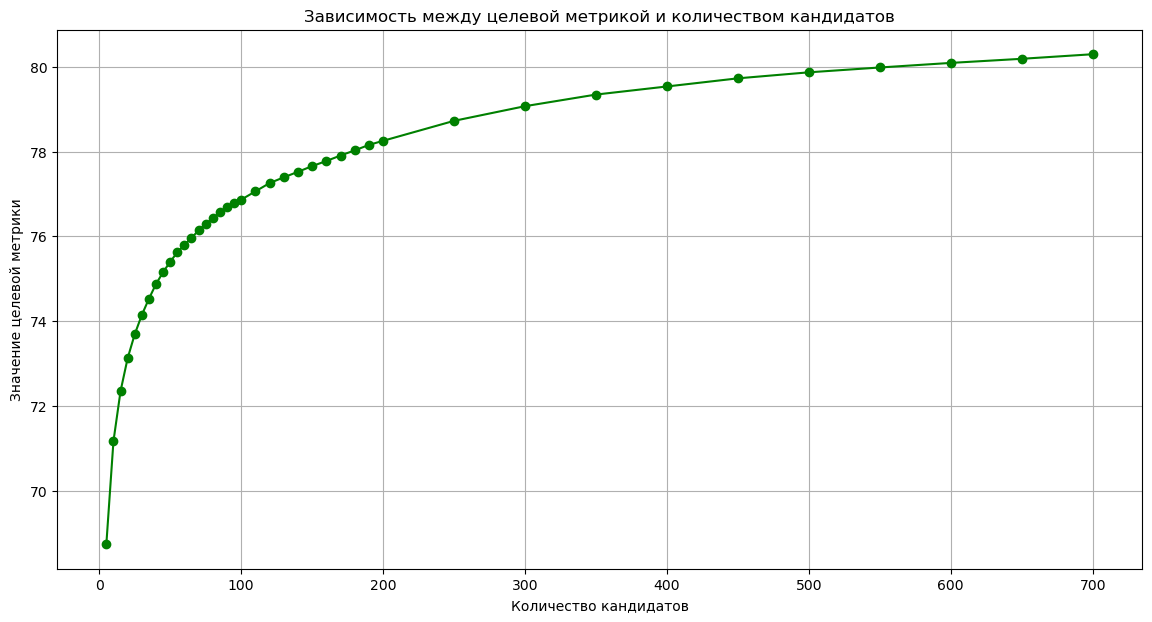

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(candidats_test.num_candidats, candidats_test.result, 'go-')
plt.grid(True)
plt.title('Зависимость между целевой метрикой и количеством кандидатов')
plt.ylabel('Значение целевой метрики')
plt.xlabel('Количество кандидатов')
plt.show()

Как видно, с увеличением метрики растетм и максимальное значение целевой метрики. Но нужно понимать, что увеличение количества кандидатов увеличит и время предсказания модели, так как ей придется в каждой иттерации просчитывать бОльшее количество кандидатов. В данном случае необходимо найти баланс между количеством кандидатов и затрачиваемого времени. В первом приближении предлагается использовать 200 кандидатов.

После подбора параметров модели Faiss проводем индексацию базы и заполнение векторов.

In [13]:
idx_l2.train(np.ascontiguousarray(df_base).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base).astype('float32'))
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

Подставим подобранное значение nprobe.

In [14]:
idx_l2.nprobe = 45

Проводим сопоставление товаров библиотекой Faiss, для получения результата по метрике accuracy@5 задаем подбор 5 кандидатов.

In [15]:
r, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 5)

Считаем метрику на тренировочном датасете.

In [16]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
    
print(100 * acc / len(idx))

70.911


На тренировочном датасете получаем значение метрики **70.911**, что является удовлетворительным результатом работы модели. Такой результат удалось достич за счет следующих манипуляций с датасетом: удаление неинформативных признаков, стандартизации признаков и подбора параметров Faiss. В случае использования индекса IndexFlatL2 можно получить результат немного лучше, по той причине, что модель ищет кандидатов во всей области пространства признаков, а не выбирая из 45 наиболее ближайших центроидов. Обратная сторона этого индекса - скорость работы модели. В текущем случае, мы уменьшили перебор кандидатов в $\sqrt n$ раз. С учетом того, что у нас приблизительно 2,9 млн кандидатов, эффект значительный.

## Подготовка ML модели

В качестве одного из варианта улучшения подбора кандидатов предложена следующая схема: 
- Подбирается бОльшее количество кандидатов;
- Среди кандидатов с помощью модели, обученной на тренировочном датасете, присваиваются вероятности;
- Список сортируется на основе предсказаний модели.

Для начала необходимо подготовить тренировочный датасет. Он состоит из правильных ответов к которым стоит добавить неверные. Неверные варианты можно получить из списка кандидатов модели Faiss. Так как приблизительно среди неверных ответов с 70% вероятностью имеется один верный, получим соотношение верных и неверных сопоставлений приблизительно 1 к 3. 

Алгоритм создания датасета следующий:
- из тренировочного датасета по ответам берем товары из базы товаров;
- из предложанных Faiss кандидатов составляем неверные ответы;
- удаляем дубликаты, так как приблизительно в 70% случаев датасет содержит один верный ответ на 5 кандидатов;
- проводим математические операции с двумя списками векторов, получаем обучающую таблицу для модели;
- по обучающей выборке проводим подбор модели с оптимальными гиперпараметрами, с учетом времени работы модели;
- подготавливаем валидационный датасет;
- создаем цикл сопоставления товаров:
 - для бОльшего числа кандидатов создаем таблицу аналогично обучающей;
 - получаем предсказания модели для каждого кандидата;
 - сортируем таблицу по предсказанию модели;
 - выбираем первых 5 кандидатов и сравниваем с ответами;
 - рассчитываем метрику accuracy@5.
- делаем анализ модели по проведенной работе.

Создаем таблицу с правильными ответами, добавляем целевой признак равный единице.

In [17]:
data_correct = pd.DataFrame(data=np.divide(np.array(df_train),np.array(df_base.loc[np.array(targets)])), 
                           index=(df_train.index), columns=(df_train.columns))
data_correct['target'] = 1
data_correct.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,66,67,68,69,71,target
Id,,,,,,,,,,,,,,,,,,,,,
66814-query,1.138024,1.441738,0.623655,1.303027,1.266616,0.084526,-1.052831,0.032286,1.762659,0.997649,...,3.252818,-17.022783,-0.163551,0.937167,0.886891,1.436990,0.134774,0.406555,1.013285,1
52632-query,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
86729-query,0.750664,1.251345,0.951212,1.455243,17.194769,0.827931,1.000000,0.588196,2.819820,0.730969,...,-1.964535,1.077410,-2.169256,0.586520,1.081962,1.185547,0.963590,1.223090,0.140335,1
67395-query,1.379753,1.776782,1.661650,0.684604,3.562225,1.204963,1.000000,0.780015,0.826128,0.831976,...,0.736627,3.159032,0.527528,1.610717,0.821843,1.521689,0.311945,1.663588,1.002245,1
12439-query,0.551303,4.266353,0.874158,2.178622,1.284229,36.536834,1.000000,4.242715,-0.146424,3.042550,...,0.629266,0.260098,0.297526,1.185414,9.291141,2.071380,0.671005,-2.074145,1.013738,1


Проверяем таблицу на размеры, дабы убедиться, что все прошло корректно.

In [18]:
data_correct.shape

(100000, 66)

Сохраняем таблицу в локальный файл.

In [19]:
#data_correct.to_csv('correct_answer.csv')

Готовим датасет неправильных ответов. Для каждого кандидата создаем таблицу и преобразуем с исходным вектором. Полученные результаты добавляем в таблицу.

In [20]:
data_incorrect = pd.DataFrame(columns=(df_train.columns))

for i in range(5):
    df_incorrect = pd.DataFrame(columns=(df_train.columns),
                                data=np.divide(np.array(df_train), 
                                               np.array(df_base.loc[list(base_index[r] for r in list(idx.T.tolist()[i]))])))
    data_incorrect = pd.concat([data_incorrect, df_incorrect], ignore_index=True)
    print(f'Process {i} successful. Shape: {data_incorrect.shape}')

Process 0 successful. Shape: (100000, 65)
Process 1 successful. Shape: (200000, 65)
Process 2 successful. Shape: (300000, 65)
Process 3 successful. Shape: (400000, 65)
Process 4 successful. Shape: (500000, 65)


Соединяем правильные и не правильные ответы, удаляем все дубликаты. Получаем датасет с неверными ответами. Указываем целевой признак равный 0.

In [21]:
data_correct = data_correct.drop(['target'], axis=1)
data_incorrect = pd.concat([data_incorrect, data_correct], ignore_index=True)
data_incorrect.drop_duplicates(keep=False, inplace=True, ignore_index=True)
data_incorrect['target'] = 0
data_incorrect['target'] = data_incorrect['target'].astype('int')

Сохраняем полученный датасет в локальной папке.

In [22]:
#data_incorrect.to_csv('data_incorrect.csv')

Для получения обучающей выборки обучающей выборки соединяем таблицы с правильными и не правильными ответами. Так как в предыдущей ячейки мы удалили целевой признак для правильных ответов, необходимо заполнить пропуски значением 1 и привести тип столбца к целому числу, иначе модель выдаст ошибку.

In [23]:
model_data = pd.concat([data_incorrect, data_correct], ignore_index=True)
model_data['target'] = model_data['target'].fillna(1)
model_data['target'] = model_data['target'].astype('int')

Так же имеет смысл перемешать данные дабы модель корректно обучилась.

In [24]:
model_data = model_data.sample(frac=1, random_state=42).reset_index(drop=True)

Сохраняем данные в соответсвующий файл, при необходимости.

In [25]:
#model_data.to_csv('model_data.csv')

Далее стоит разделить обучающую выборку на признаки и целевой признак.

In [26]:
model_features = model_data.drop(['target'], axis=1)
model_target = model_data['target']

Как говорилось ранее, признак 6 принят категориальным и при совпадении этого признака между вектором и правильным ответом, мы получаем значение 1. Остальные же значения приведек к другой категории - 0.

In [27]:
model_features['6'] = model_features['6'].map(lambda x: 1 if x==1 else 0)

Разделим все признаки на категориальные и числовые.

In [28]:
columns_category = ['6']
columns_numeric = model_features.columns.difference(columns_category)

Приведем категориальные признаки к типу 'object', иначе в процессе подготовки данных колоночный трансформер не воспримет признак как категория и укажет, что в датасете нет категориальных признаков.

In [29]:
model_features[columns_category] = model_features[columns_category].astype('object')

### Optuna

Для подготовки модели осталось получить лучшие гиперпараметры. Лучшее, на данный момент, решение это воспользоваться библиотекой Optuna. В отличии от random search или grid search, в ней реализован улучшенный алгоритм подбора гиперпараметров за счет sampler и pruner. 

**Optuna** — это фреймворк для для автоматизированного поиска оптимальных гиперпараметров для моделей машинного обучения. Она подбирает эти параметры методом проб и ошибок.

Ключевые особенности фреймворка:
- настраиваемое пространство поиска гиперпараметров. Разработчик может самостоятельно задать пространство для поиска гиперпараметров, используя базовый синтаксис Python (циклы, условия);
- алгоритмы SoTA для выбора гиперпараметров из пространства заданного разработчиком (samplers) и для ранней остановки бесперспективных экспериментов (pruners). В Optuna представлены различные алгоритмы семплирования и прунинга, разработчик может выбрать какой-то конкретный, оставить дефолтный, или написать свой собственный;
- легкость расспаралеливания процесса поиска гиперпараметров. Также к Optuna можно прикрутить dashboard с визуализацией обучения в реальном времени.

Так же в Optunа можно добавить pipline и кросс-валидацию. Код подготовлен для 2 моделей - LightGBM и XGBoost. В предварительном испытании XGBoost показал результат немного лучше чем LightGBM, но для увеличении скорости требует использовать ресурсы GPU. Если такая возможность отсутствует, следует использовать модель LightGBM, скорость работы которой значительно превышает вторую модель. 

В качестве метрики выбрана **F1**, так как в отличии от accuracy дисбаланс классов на нее не влияет, а у нас соотношение правильных и неправильных ответов 1 к 3.5.

In [30]:
def objective(trial: optuna.Trial):
    
    
    model_type = trial.suggest_categorical("model_type", ["XGBoost"])
    
    if model_type == "LightGBM":
        lgbm_params = {
            'max_depth': trial.suggest_int('max_depth', 5, 17),
            'learning_rate': trial.suggest_float('learning_rate', 0.008, 0.1, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
            'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 20),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),
            'lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
            'random_state': trial.suggest_categorical('random_state', [42]),
            'n_jobs': trial.suggest_categorical('n_jobs', [-1]),            
        }
        
        model = LGBMClassifier(verbose=-1, **lgbm_params)
        
        preprocessor = ColumnTransformer(
            transformers=[
                ("numeric", StandardScaler(), columns_numeric),
                ("category", TargetEncoder(), columns_category)
            ]
        )
       

    elif model_type == "XGBoost":
        xgboost_params = {
            'tree_method':'gpu_hist',  
            'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_float('learning_rate', 0.008, 0.02, log=True),
            'n_estimators': 1000,
            'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
            'random_state': trial.suggest_categorical('random_state', [42]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }
        
        model = XGBClassifier(**xgboost_params)
        
        preprocessor = ColumnTransformer(
            transformers=[
                ("numeric", StandardScaler(), columns_numeric),
                ("category", TargetEncoder(), columns_category)
            ]
        )
       
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    cv = KFold(n_splits=4)
    scorer = make_scorer(f1_score)
    score = cross_val_score(estimator=pipe,
                            X=model_features,
                            y=model_target,
                            scoring=scorer,
                            cv=cv)
    
    trial.set_user_attr("model", pipe)
    trial.set_user_attr("cross_val_score", score)
    
    f1 = score.mean()
    return f1  

Напишем функцию для вывода значений метрик при кросс-валидации

In [31]:
# Определение Callback для вывода метрик
def custom_callback(study: optuna.Study, trial: optuna.Trial):
    trial.user_attrs["cross_val_score"]
    score = trial.user_attrs["cross_val_score"]
    print(f"Trial {trial.number}: cross_val_score={score}")

Samplers в Optuna это набор алгоритмов для поиска гиперпараметров.Зададим поиск гиперпараметров с минимизацией метрики, sampler - TPESampler, pruner - HyperbandPruner. 

Samplers в Optuna это набор алгоритмов для поиска гиперпараметров. 

Pruners в Optuna - это набор алгоритмов для прореживания экспериментов. Pruning - это механизм который позволяет обрывать эксперименты , которые с большой долей вероятности приведут к не оптимальным результатам.

In [32]:
study = optuna.create_study(direction="maximize", 
                            sampler = TPESampler(seed=42),
                            pruner = optuna.pruners.HyperbandPruner(),
                            study_name=f"Pipeline_training_example_{dt.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
study.optimize(objective, n_trials=5, callbacks=[custom_callback])

[I 2023-10-23 19:43:52,127] A new study created in memory with name: Pipeline_training_example_2023-10-23_19-43-52
[I 2023-10-23 19:46:03,455] Trial 0 finished with value: 0.5401146102503261 and parameters: {'model_type': 'XGBoost', 'lambda': 0.03148911647956861, 'alpha': 6.351221010640703, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.010572072866769694, 'max_depth': 11, 'random_state': 42, 'min_child_weight': 137}. Best is trial 0 with value: 0.5401146102503261.


Trial 0: cross_val_score=[0.53846154 0.5418566  0.53921542 0.54092488]


[I 2023-10-23 19:47:37,931] Trial 1 finished with value: 0.5386839499793354 and parameters: {'model_type': 'XGBoost', 'lambda': 1.382623217936987, 'alpha': 0.006290644294586149, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.012593333102215698, 'max_depth': 7, 'random_state': 42, 'min_child_weight': 56}. Best is trial 0 with value: 0.5401146102503261.


Trial 1: cross_val_score=[0.53712898 0.53986223 0.53749298 0.54025161]


[I 2023-10-23 19:49:21,997] Trial 2 finished with value: 0.5305167766563058 and parameters: {'model_type': 'XGBoost', 'lambda': 7.556810141274429, 'alpha': 1.2604664585649468, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.009102682068690582, 'max_depth': 9, 'random_state': 42, 'min_child_weight': 213}. Best is trial 0 with value: 0.5401146102503261.


Trial 2: cross_val_score=[0.52986683 0.53082699 0.52984276 0.53153053]


[I 2023-10-23 19:51:35,984] Trial 3 finished with value: 0.5297507314510219 and parameters: {'model_type': 'XGBoost', 'lambda': 0.8241925264876453, 'alpha': 1.2164139351417065, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.015378664546330346, 'max_depth': 9, 'random_state': 42, 'min_child_weight': 33}. Best is trial 0 with value: 0.5401146102503261.


Trial 3: cross_val_score=[0.52928012 0.53018733 0.52988973 0.52964575]


[I 2023-10-23 19:54:26,617] Trial 4 finished with value: 0.5342152590109732 and parameters: {'model_type': 'XGBoost', 'lambda': 0.0013357240411974098, 'alpha': 0.35127047262708466, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.016707184177862246, 'max_depth': 13, 'random_state': 42, 'min_child_weight': 69}. Best is trial 0 with value: 0.5401146102503261.


Trial 4: cross_val_score=[0.5321057  0.53634204 0.53498051 0.53343279]


При подготовке данных модель количество попыток модели равнялось 50, для сдачи проекта, дабы проверить работоспособность кода оставил 5 попыток. Результат лучшей модели на 50 попытка 0.545, со следующими гиперпараметрами:

- 'lambda': 0.2983818712595491, 
- 'alpha': 2.3292598010686607, 
- 'colsample_bytree': 0.6, 
- 'subsample': 0.5, 
- 'learning_rate': 0.019912842140713385, 
- 'max_depth': 17, 
- 'random_state': 42, 
- 'min_child_weight': 255.

Для улучшения результатов подбора похожих товаров получена модель классификации XGBoost. Теперь готовим валидационный датасет и создаем цикл с подсчетом итоговой метрики. 

## Ансамбль ранжирующей модели и модели классификации

Загружаем признаки валидационного датасета, удаляем из признаков столбцы аналогично базе товаров и тренировочного. После загружаем ответы и сравниваем вариант без модели с вариантом с моделью.

In [33]:
test_features = pd.read_csv('validation.csv', index_col=0)
test_features = test_features.drop(['21', '25', '33', '44', '59', '65', '70'], axis=1)

In [34]:
test_target = pd.read_csv('validation_answer.csv', index_col=0) 

In [35]:
test_features[test_features.columns] = scaler.transform(test_features[test_features.columns])

In [36]:
%%time

r, idx = idx_l2.search(np.ascontiguousarray(test_features.values).astype('float32'), 200)

Wall time: 1min 5s


In [37]:
acc = 0
for target, el in zip(test_target['Expected'].values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el[:5]])
    
print(100 * acc / len(idx))

70.796


Для модели без использования ml модели получаем метрику accyracy@5 равную **70.796**, что соответсвует удовлетворительному результату работы. Попробуем улучшить результат с помощью модели классификации. 

Создадим модель с подобранными гиперпараметрами, предобработаем категориальный признак и обучим модель на обучающей выборке.

In [38]:
model = XGBClassifier(reg_lambda=0.2983818712595491, alpha=2.3292598010686607, tree_method='gpu_hist',
                      colsample_bytree=0.6, subsample=0.5, learning_rate=0.019912842140713385, 
                      max_depth=17, random_state=42, min_child_weight=255, n_estimators=1000)

In [39]:
target_encod = TargetEncoder()
target_encod.fit(model_features[columns_category], model_target)
model_features[columns_category] = target_encod.transform(model_features[columns_category])
model.fit(model_features, model_target)

XGBClassifier(alpha=2.3292598010686607, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.019912842140713385,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=255, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

Теперь осталось посчитать метрику на валидационной выборке с применением ml модели. Код выполняется значительное время. В ячейке описаны основные шаги алгоритма оценки ранжирующей модели с моделью машинного обучения.

In [40]:
acc = 0

for index, target, el in zip(test_features.values, test_target['Expected'].values.tolist(), idx.tolist()):
    # Создаем заготовку таблицы для предсказания модели 
    table = pd.DataFrame(index=range(200), columns=test_features.columns)
    # Заполняем значения исходным вектором
    table[:] = index
    # Производим деление исходного вектора на вектор найденных кандидатов
    table = pd.DataFrame(dtype='float32', columns=(test_features.columns), 
                         data=np.divide(np.array(table), 
                                        np.array(df_base.loc[list([base_index[r] for r in el])])))
    # Признак 6 в основном принимает значение 1 для верных вариантов, поэтому делаем его категориальным
    table['6'] = table['6'].map(lambda x: 1 if x==1 else 0)
    table['6'] = table['6'].astype('object')
    # Кодируем признак
    table['6'] = target_encod.transform(table['6'])
    # Получаем столбец с предсказаниями и добавляем его к исходному
    predict = model.predict_proba(table)[:,1]
    el = np.array(el)
    proba_el = pd.DataFrame(el.T.tolist())
    proba_el[1] = predict
    # Сортируем таблицу по предсказанию модели, после оставляем 5 лучших кандидата по версии модели
    proba_el = proba_el.sort_values(by=[1], ascending=False)
    el = np.array(proba_el[0])[:5]
    # Рассчитываем метрику accuracy@5
    acc += int(target in [base_index[r] for r in el])
    
print(100 * acc / len(idx))

59.785


Ансамбль моделей ранжирования и классификации на 200 кандидатах выдает результат 59,785. При уменьшении количества кандидатов до 10 результат увеличивается до 65,8%, что хуже модели без ансамбля с моделью классификации.  Из этого следует, что использование имеющейся модели ухудшает предсказания модели Faiss. Модель классификации не верно предсказывает какой из кандидатов более похож на вектор запроса.

## Итоговый вывод

Для проекта Мастерской разработана модель ранжирования библиотеки Faiss, позволяющая определить наиболее схожие товары метоом ближайших соседей по векторам признаков. В дополнение к Faiss внедрена модель классификации XGBoost, позволяющая из бОльшего числа кандидатов определить какие из них схожи с исходным вектором, а какие нет. По вероятности предсказания модели классификации сортируются кандидаты. 

Среди исходных признаков имелись такие, у которых значения имели не нормальлное распределение. В результате математических операций выявлено, что один из признаков, в большинстве случаев, для верных ответов имел значение равное единице, а для остальных кандидатов отличался от единицы. Так же вероятно что часть других признаков являлись категориальные и по этой причине имели отличное от нормального распределения. Интересным замечанием было отличие указанных признаков по количеству символов после запятой.

После удаления данных признаков в тестовой выборке появилось порядка 2% дубликатов. 

Для модели ранжирования Faiss подобраны параметры и модель с точностью 70,9% верно сопоставляла один из пяти кандидатов. При этом время на разметку и сопоставление кандидатов адекватные. При использовании индекса Flat можно немного улучшить результат, но при этом время поиска кандидатов сильно увеличится, за счет того, что модель будет сравнивать с каждым кандидатом в базе по отдельности и при увеличении базы (а они иногда достигают десятков и сотен Гб) скорость поиска будет увеличиваться.

Другим способом улучшение результат является подбор большего количества кандидатов. Например среди 100 кандидатов метрика увеличится до 76,9%, а при 200 уже 78,3%, далее увеличение количества кандидатов недает такой прирост в результате. Такой метод удобно использовать с моделью классификации, в случае если модель верно предсказывает в более чем 90,5% случаев.

В качестве такой модели испробована модель классификации XGBoost. Для нее подобраны оптимальные гиперпараметры с помощью библиотеки Optuna. С указанными гиперпараметрами модель из 200 кандидатов выводит с вероятностью 53% из 5 кандидатов предлагает верный. С вероятность. 65,8% из 10 кандидатов выбирает 5 с одним правильным.  К сожалению при имеющейся конфигурации модели, результат метрики ухудшается и в реализацию запускать нет смысла. 

Рекомендации для улучшения качества предсказаний:
- среди удаленных признаков проверить на принадлежность к категориальным;
- воспользоваться другими моделями машинного обучения для классификации;
- воспользоваться другой ранжирующей моделью;
- провести альтернативные математические операции с векторами (в текущей работе использовано деление исходного вектора на вектора кандидатов).